# Variational Autoencoder

Implementation of VAE from the paper:
 Auto-Encoding Variational Bayes by Kingma & Welling (https://arxiv.org/abs/1312.6114)

In [1]:
import torch

In [2]:
print(torch.__version__)

1.0.0


In [3]:
# import torchvision
import torchvision
from torchvision.transforms import ToTensor

In [4]:
from torch.nn import functional as F
from torch import nn

In [5]:
class FlatView(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [6]:
class FCNet(nn.Module):
    """
    fully connected network
    """
    def __init__(self, 
                 in_size=28**2, 
                 output_size=10, 
                 n_layers=2,
                 hidden_size=20,
                 nonlinearity=nn.ReLU):
        super().__init__()
        self.layer_ops = [
            FlatView(),
            nn.Linear(in_features=in_size, out_features=hidden_size),
            nonlinearity(),            
        ]
        
        for __ in range(n_layers - 1):
            self.layer_ops.append(nn.Linear(in_features=hidden_size, out_features=hidden_size))
            self.layer_ops.append(nonlinearity())
        
        self.layer_ops.append(nn.Linear(in_features=hidden_size, out_features=output_size))
        
        self.layers = nn.Sequential(*self.layer_ops)
    
    
    def forward(self, x):
        return self.layers(x)
        
        

In [7]:
class FCEncoder(nn.Module):
    """
    Q function that approximates the prior p(z)
    q(z/x) approx p(z)
    fully connected encoder network
    """
    def __init__(self,
                 in_size=28,
                 hidden_size=200,
                 n_layers=2,
                 latent_size=2,
                 nonlinearity=nn.Tanh):
        super().__init__()
        self.encoder_op = FCNet(in_size=in_size, output_size=hidden_size, n_layers=n_layers,
                               hidden_size=hidden_size, nonlinearity=nonlinearity)
        
        # read the mu and sigma
        self.encoder_mu = nn.Linear(in_features=hidden_size, out_features=latent_size)
        self.encoder_log_sigma = nn.Linear(in_features=hidden_size, out_features=latent_size)
        
    
    def forward(self, x):
        hidden = self.encoder_op(x)
        encoder_mu = self.encoder_mu(hidden)
        encoder_log_sigma = self.encoder_log_sigma(hidden)
        return encoder_mu, encoder_log_sigma
        
    

In [8]:
class VAE(nn.Module):
    """
    The VAE network
    """
    def __init__(self, 
                 in_size=28**2, 
                 hidden_size=200, 
                 n_layers=2, 
                 latent_size=2, 
                 nonlinearity=nn.Tanh):
        super().__init__()
        
        self.latent_size = latent_size
        
        # q(z/x) that approximates p(z)
        self.q_z_x_op = FCEncoder(in_size=in_size, 
                              hidden_size=hidden_size,
                              n_layers=n_layers,
                              latent_size=latent_size,
                              nonlinearity=nonlinearity)
        
        # p(x/z)
        self.p_x_z_op = FCNet(in_size=latent_size,
                                output_size=in_size,
                                n_layers=n_layers,
                                hidden_size=hidden_size,
                                nonlinearity=nonlinearity)
        
    def forward(self, x):
        q_z_x_mu, q_z_x_logsig = self.q_z_x_op(x)
        
        # randomly sample from a unit-variance multivariate Gaussian
        epsilon = torch.randn_like(q_z_x_logsig)
        
        z = q_z_x_mu + epsilon * torch.exp(0.5 * q_z_x_logsig)
        
        p_x_z_logmu = self.p_x_z_op(z)
        
        return p_x_z_logmu, q_z_x_mu, q_z_x_logsig
    
    
    def generate(self, n=1, z_sim=None):
        if z_sim is None:
            z_sim = torch.randn(n, self.latent_size)
        return torch.sigmoid(self.p_x_z_op(z_sim))
            

In [25]:
def elbo_logistic(x, p_x_z_logmu, q_z_x_mu, q_z_x_logsig, manual_logistic_loss=False):
    """
    evidence lower bound - ELBO
    applying logistic loss for likelihood
    """
    x_flattened = FlatView()(x)    
    
    # reconstruction loss is a logistic loss
    
    if manual_logistic_loss:
        # note logistic loss assume that input comes through a sigmoid layer
        
        # p_x_z_logmu is interpreted as logit 
        # logit(p) = log odds(p) = log (p/(1-p)))
        # so sigmoid(p_x_z_logmu) = logistic(p_x_z_logmu) = logistic(logit(p)) = p
        # which gives the following equation
        reconstruction_loss = -torch.sum(x_flattened * torch.log(1e-10 + p_x_z_mu) + 
                                        (1 - x_flattened) * torch.log(1e-10 + 1 - p_x_z_mu), 
                                        dim=1)
    else:
        reconstruction_loss = torch.sum(
                torch.nn.functional.binary_cross_entropy_with_logits(p_x_z_logmu,
                                                                     x_flattened,
                                                                     reduction="none"),
                dim=1
        )
    
    # regularization to keep the q(z/x) close to p(z) using KL-divergence
    # note that q(z/x) is multitvariante guassian with (mu, sigma) and
    #           p(z) is unit-variance
    # eqn. from the paper
    regularization = -0.5 * torch.sum(1 + q_z_x_logsig - q_z_x_mu.pow(2) - q_z_x_logsig.exp(),
                                    dim=1)
    
    return torch.mean(reconstruction_loss + regularization)
    

In [29]:
def train_model(model, train_loader, optimizer, epoch, log_interval=10, manual_logistic_loss=False):
    
    # mark the model for training
    model.train()
    
    for batch_idx, (data, __) in enumerate(train_loader):
        optimizer.zero_grad()
        p_x_z_logmu, q_z_x_mu, q_z_x_logsig = model(data)
        loss = elbo_logistic(data, p_x_z_logmu, q_z_x_mu, q_z_x_logsig, manual_logistic_loss)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage ELBO: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [30]:
# load MNIST
mnist = torchvision.datasets.MNIST('/tmp/mnist/',transform=ToTensor(),download=True, train=True)
mnist_loader = torch.utils.data.DataLoader(mnist, batch_size=100, shuffle=True)

In [31]:
# training! 

n_epochs = 5
vae = VAE(in_size = 28 ** 2, hidden_size=200, n_layers=2)
optimizer = torch.optim.Adam(vae.parameters())

for epoch in range(n_epochs):
    train_model(vae, mnist_loader, optimizer, epoch, log_interval=100, manual_logistic_loss=False)

Train Epoch: 0 [0/60000 (0%)]	Average ELBO: 545.921387
Train Epoch: 0 [10000/60000 (17%)]	Average ELBO: 193.887955
Train Epoch: 0 [20000/60000 (33%)]	Average ELBO: 194.465607
Train Epoch: 0 [30000/60000 (50%)]	Average ELBO: 174.877441
Train Epoch: 0 [40000/60000 (67%)]	Average ELBO: 175.675003
Train Epoch: 0 [50000/60000 (83%)]	Average ELBO: 164.704437
Train Epoch: 1 [0/60000 (0%)]	Average ELBO: 178.637268
Train Epoch: 1 [10000/60000 (17%)]	Average ELBO: 159.232117
Train Epoch: 1 [20000/60000 (33%)]	Average ELBO: 169.709869
Train Epoch: 1 [30000/60000 (50%)]	Average ELBO: 159.383881
Train Epoch: 1 [40000/60000 (67%)]	Average ELBO: 163.240326
Train Epoch: 1 [50000/60000 (83%)]	Average ELBO: 164.860123
Train Epoch: 2 [0/60000 (0%)]	Average ELBO: 159.751694
Train Epoch: 2 [10000/60000 (17%)]	Average ELBO: 154.989868
Train Epoch: 2 [20000/60000 (33%)]	Average ELBO: 153.742477
Train Epoch: 2 [30000/60000 (50%)]	Average ELBO: 161.135483
Train Epoch: 2 [40000/60000 (67%)]	Average ELBO: 152.11

## Test reconstruction

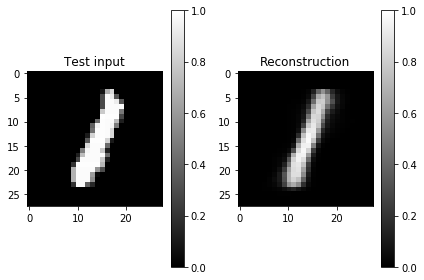

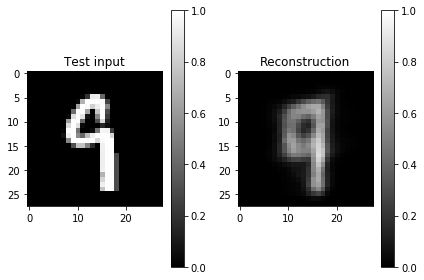

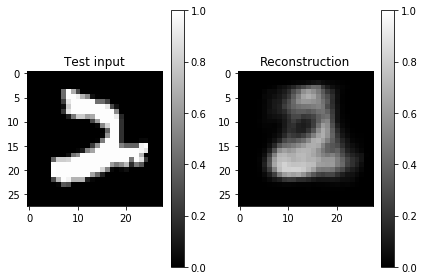

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# plot some random examples
rand_indices = np.random.randint(low=0, high=len(mnist), size=3)

# set model in eval mode
vae.eval()

for idx in rand_indices:
    x_sample, _  = mnist[idx]
    log_x_reconstruct, _, _ = vae(x_sample)
    x_reconstruct = torch.sigmoid(log_x_reconstruct)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(x_sample.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    
    # to create a numpy array from a tensor that has gradients
    # first detach, which will create a tensor without any gradients
    # and then convert to numpy array
    x_reconstruct_np = x_reconstruct.detach().numpy()
    plt.imshow(x_reconstruct_np.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    plt.tight_layout()    


## Test generative model

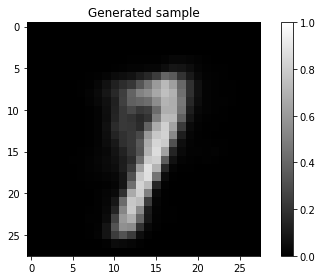

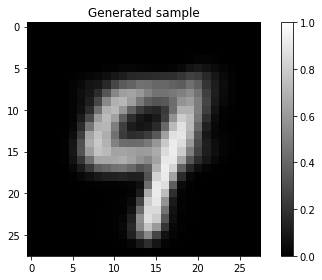

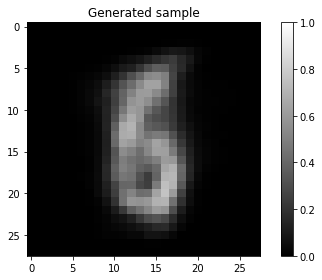

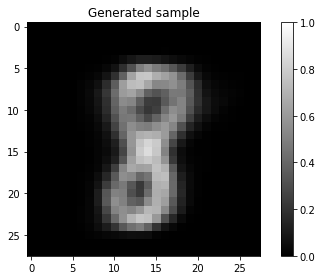

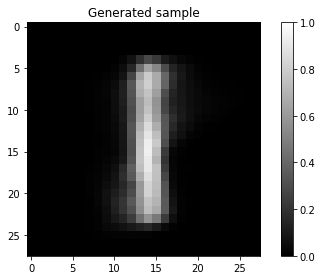

In [33]:
# set model in eval mode
vae.eval()

for idx in range(5):
    plt.figure()
    plt.imshow(vae.generate().detach().numpy().reshape(28,28), vmin=0, vmax=1, cmap="gray")
    plt.title("Generated sample")
    plt.colorbar()
    plt.tight_layout()

## plot the latent 2d space

In [41]:
def create_cartesian_product(arr):
    """
    given an one-dimensional array, it creates a
    2D array of the cartesian product
    input: 1D ndarray
    output: 2D ndarray where each column is an element of the cartesian product
    """
    assert np.ndim(arr) == 1
    return np.concatenate(np.meshgrid(arr, arr)).reshape(2, -1)
    

In [42]:
from scipy.stats import norm

In [43]:
gridsize = 25
sweep_of_latent_space_0_axis = norm.ppf(np.linspace(0.0001, 0.999, gridsize)).astype(np.float32)

In [44]:
sweep_of_latent_space_0_axis.shape

(25,)

In [45]:
sweep_of_latent_space = create_cartesian_product(sweep_of_latent_space_0_axis)

In [46]:
# each column corresponds to a point in the 2D latent-space
sweep_of_latent_space.shape

(2, 625)

In [47]:
sweep_of_latent_space = sweep_of_latent_space.T

In [48]:
# each row corresponds to a point in the latent space
# we are creating a batch of grid_size**2 samples
sweep_of_latent_space.shape

(625, 2)

In [49]:
output_sweep = vae.generate(z_sim=torch.tensor(sweep_of_latent_space))

In [50]:
output_sweep.shape

torch.Size([625, 784])

In [51]:
output_sweep.detach().numpy().reshape(gridsize, gridsize, 28, 28).shape

(25, 25, 28, 28)

In [52]:
output_sweep.detach().numpy().reshape(gridsize, gridsize, 28, 28).swapaxes(1,2).shape

(25, 28, 25, 28)

In [53]:
image_grid = output_sweep.detach().numpy().reshape(gridsize, gridsize, 28, 28).swapaxes(1,2).reshape(gridsize*28, gridsize*28)

In [54]:
image_grid.shape

(700, 700)

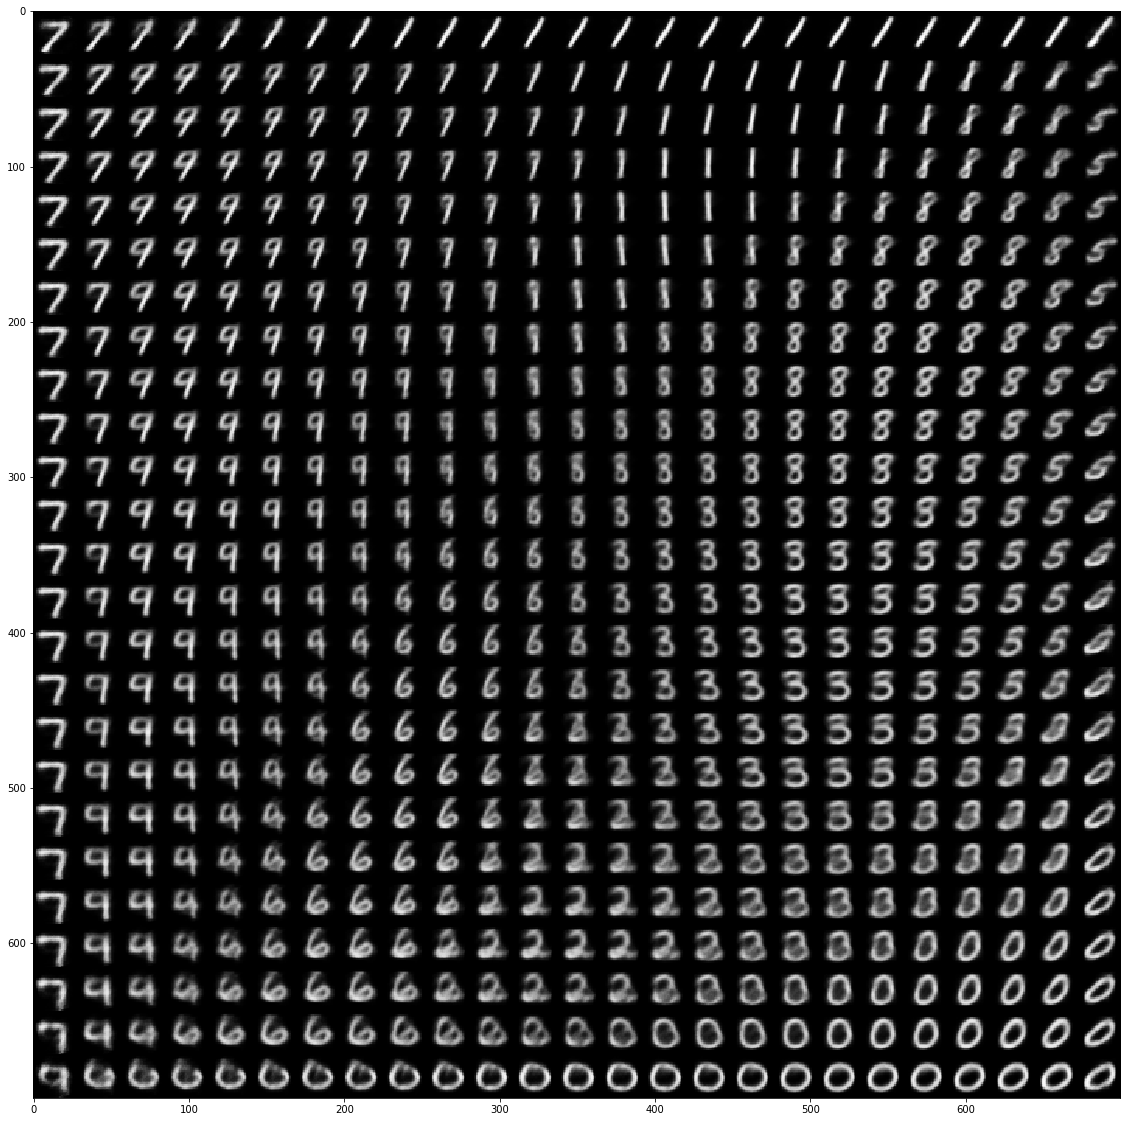

In [55]:
plt.figure(figsize=(20, 20))
plt.imshow(image_grid, cmap="gray")